This notebook was completed with the assistance of my team as the final project for Digital Image Processing (DIP) at college. We utilized a Kaggle dataset and referenced notebooks available there for learning purposes.

#**Preparation**

In [1]:
!pip install imutils

In [2]:

! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

## import library

In [4]:
# Import Libraries

# Warning
import warnings
warnings.filterwarnings("ignore")

# Main
import os
import glob
import cv2
import numpy as np
import pandas as pd
import gc
import string
import time
import random
import imutils
from PIL import Image
from tqdm import tqdm
tqdm.pandas()

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.manifold import TSNE

# Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import (VGG16, DenseNet121)
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, MaxPooling2D, Conv2D, GlobalAveragePooling2D
from keras.models import load_model, Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [5]:
# Configuration
batch_size = 64
img_height = 64
img_width = 64
epochs = 5
num_classes = 29
img_channels = 3

# set seed
random.seed(5555)
np.random.seed(5555)
tf.random.set_seed(5555)

#**Data Exploration**

In [6]:
!kaggle datasets download -d grassknoted/asl-alphabet

100% 1.02G/1.03G [00:08<00:00, 127MB/s]
100% 1.03G/1.03G [00:08<00:00, 131MB/s]


In [7]:
!unzip asl-alphabet.zip -d asl-alphabet

Streaming output truncated to the last 5000 lines.
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alphabet_train/nothing/nothing1907.jpg  
  inflating: asl-alphabet/asl_alphabet_train/asl_alp

In [8]:
# Labels
TRAIN_PATH = "asl-alphabet/asl_alphabet_train/asl_alphabet_train"
labels = []
alphabet = list(string.ascii_uppercase)
labels.extend(alphabet)
labels.extend(["del", "nothing", "space"])
print(labels)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [9]:
def sample_images(labels):
    # Create Subplots
    y_size = 12
    if(len(labels)<10):
        y_size = y_size * len(labels) / 10
    fig, axs = plt.subplots(len(labels), 9, figsize=(y_size, 13))

    for i, label in enumerate(labels):
        axs[i, 0].text(0.5, 0.5, label, ha='center', va='center', fontsize=8)
        axs[i, 0].axis('off')

        label_path = os.path.join(TRAIN_PATH, label)
        list_files = os.listdir(label_path)

        for j in range(8):
            img_label = cv2.imread(os.path.join(label_path, list_files[j]))
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            axs[i, j+1].imshow(img_label)
            axs[i, j+1].axis("off")

    # Title
    plt.suptitle("Sample Images in ASL Alphabet Dataset", x=0.55, y=0.92)

    # Show
    plt.show()

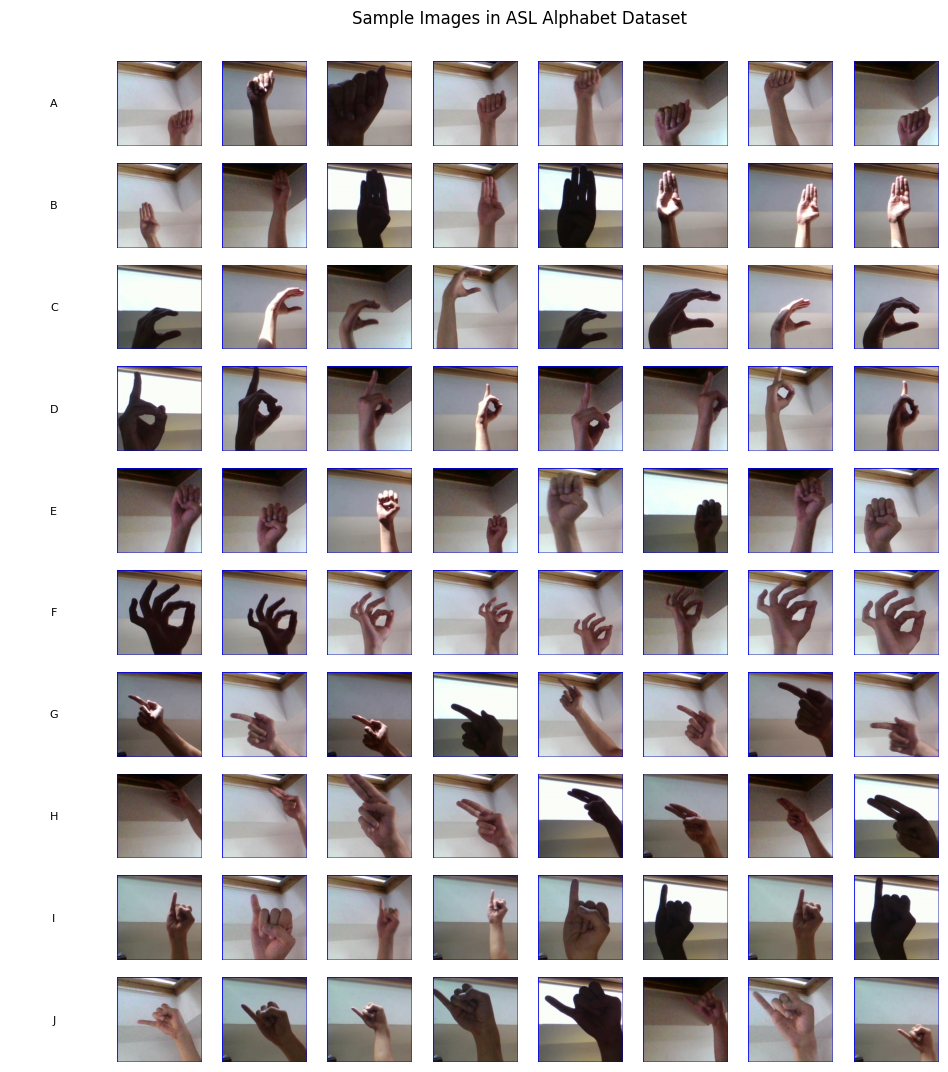

In [10]:
sample_images(labels[:10])

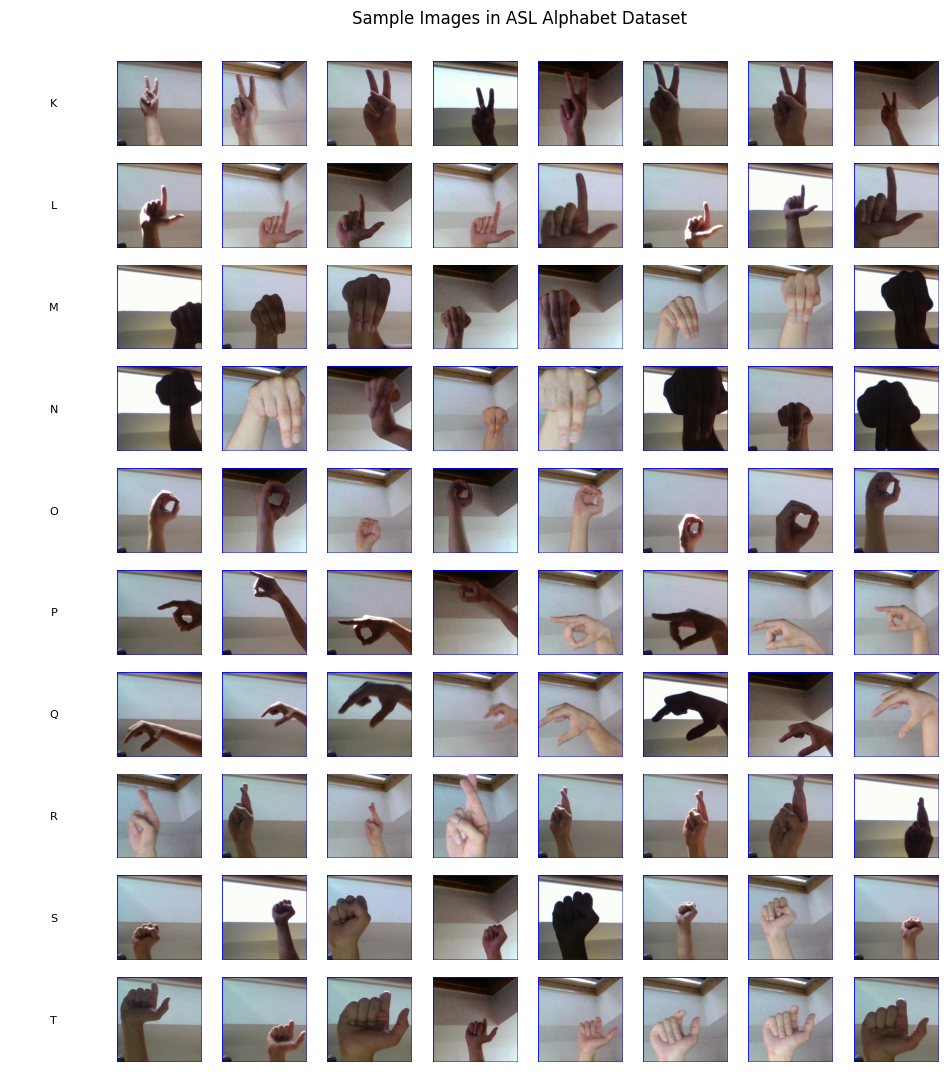

In [11]:
sample_images(labels[10:20])

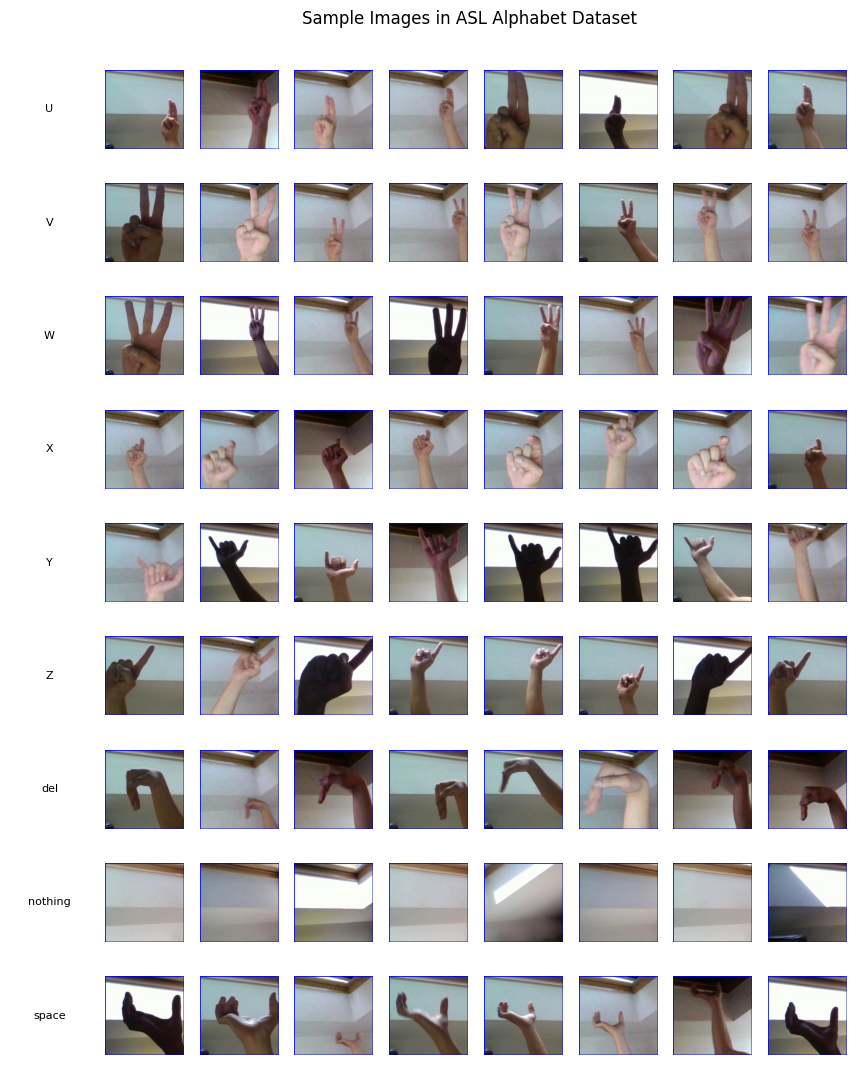

In [12]:
sample_images(labels[20:])

#**Data Preprocessing**

In [13]:
import os
from PIL import Image, ImageOps

def remove_border(image_path, border_size=5):
    img = Image.open(image_path)
    img_without_border = ImageOps.crop(img, border_size)

    img_without_border.save(image_path)


def process_test_images(input_folder, border_size=5):
    for filename in os.listdir(input_folder):
        image_path = os.path.join(input_folder, filename)

        remove_border(image_path, border_size)

def process_train_images(input_folder, border_size=5):
    for sub_folder in os.listdir(input_folder):
      sub_folder = os.path.join(input_folder, sub_folder)
      for filename in os.listdir(sub_folder):
          image_path = os.path.join(sub_folder, filename)

          remove_border(image_path, border_size)

process_train_images('/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train',  border_size=5)
process_test_images('/content/asl-alphabet/asl_alphabet_test/asl_alphabet_test',  border_size=5)

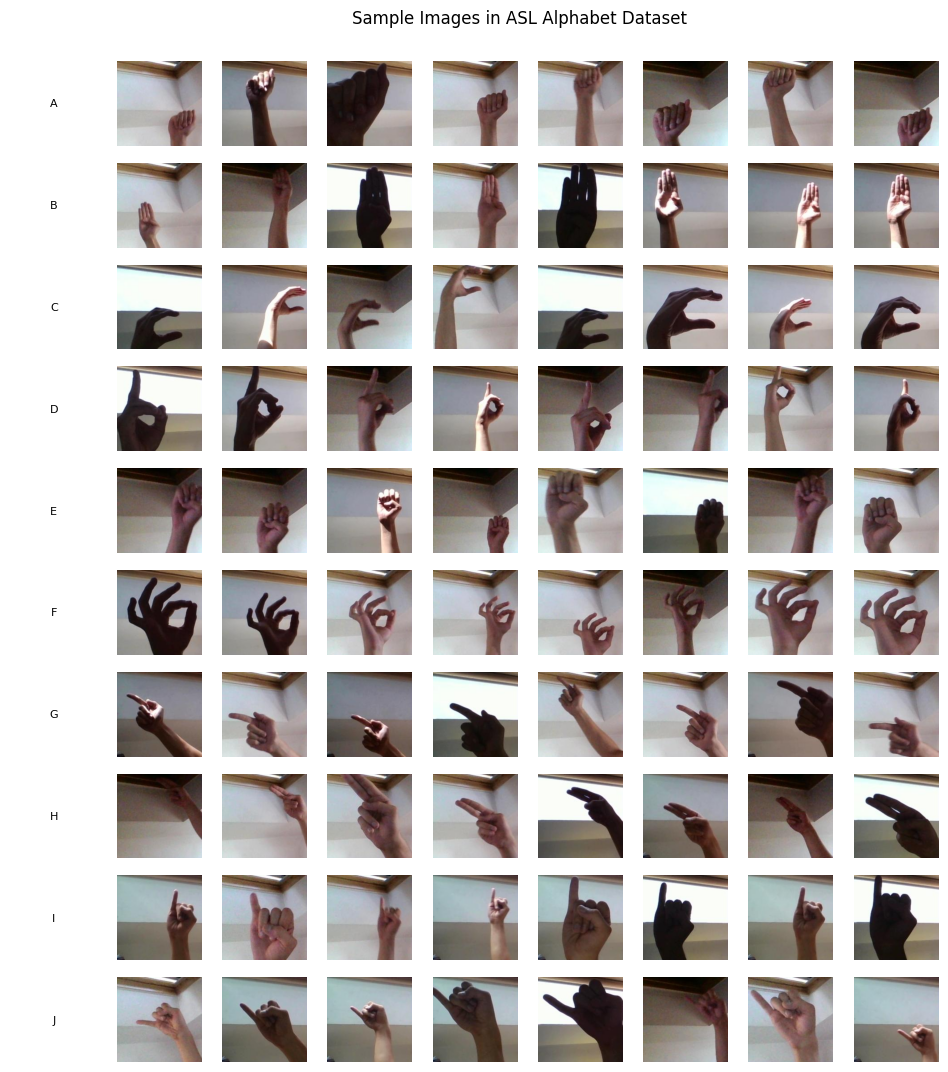

In [14]:
sample_images(labels[:10])

In [15]:
# Create Metadata
list_path = []
list_labels = []
for label in labels:
    label_path = os.path.join(TRAIN_PATH, label, "*")
    image_files = glob.glob(label_path)

    sign_label = [label] * len(image_files)

    list_path.extend(image_files)
    list_labels.extend(sign_label)

metadata = pd.DataFrame({
    "image_path": list_path,
    "label": list_labels
})

metadata

image_path  label
0      asl-alphabet/asl_alphabet_train/asl_alphabet_t...      A
1      asl-alphabet/asl_alphabet_train/asl_alphabet_t...      A
2      asl-alphabet/asl_alphabet_train/asl_alphabet_t...      A
3      asl-alphabet/asl_alphabet_train/asl_alphabet_t...      A
4      asl-alphabet/asl_alphabet_train/asl_alphabet_t...      A
...                                                  ...    ...
86995  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  space
86996  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  space
86997  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  space
86998  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  space
86999  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  space

[87000 rows x 2 columns]

In [16]:
# Split Dataset to Train 0.7, Val 0.15, and Test 0.15
X_train, X_test, y_train, y_test = train_test_split(
    metadata["image_path"], metadata["label"],
    test_size=0.15,
    random_state=5555,
    shuffle=True,
    stratify=metadata["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})

X_train, X_val, y_train, y_val = train_test_split(
    data_train["image_path"], data_train["label"],
    test_size=0.15/0.70,
    random_state=5555,
    shuffle=True,
    stratify=data_train["label"]
)
data_train = pd.DataFrame({
    "image_path": X_train,
    "label": y_train
})
data_val = pd.DataFrame({
    "image_path": X_val,
    "label": y_val
})
data_test = pd.DataFrame({
    "image_path": X_test,
    "label": y_test
})

display(data_train)
display(data_val)
display(data_test)

image_path label
33447  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     L
13130  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     E
67129  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     W
76448  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     Z
67912  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     W
...                                                  ...   ...
4508   asl-alphabet/asl_alphabet_train/asl_alphabet_t...     B
66474  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     W
37474  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     M
59972  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     T
60081  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     U

[58103 rows x 2 columns]

image_path label
42857  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     O
48747  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     Q
79285  asl-alphabet/asl_alphabet_train/asl_alphabet_t...   del
27121  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     J
77280  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     Z
...                                                  ...   ...
14484  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     E
36719  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     M
18033  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     G
10918  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     D
25437  asl-alphabet/asl_alphabet_train/asl_alphabet_t...     I

[15847 rows x 2 columns]

image_path    label
10760  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        D
72685  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        Y
63505  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        V
82898  asl-alphabet/asl_alphabet_train/asl_alphabet_t...  nothing
62079  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        U
...                                                  ...      ...
86653  asl-alphabet/asl_alphabet_train/asl_alphabet_t...    space
55697  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        S
53532  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        R
75551  asl-alphabet/asl_alphabet_train/asl_alphabet_t...        Z
80162  asl-alphabet/asl_alphabet_train/asl_alphabet_t...      del

[13050 rows x 2 columns]

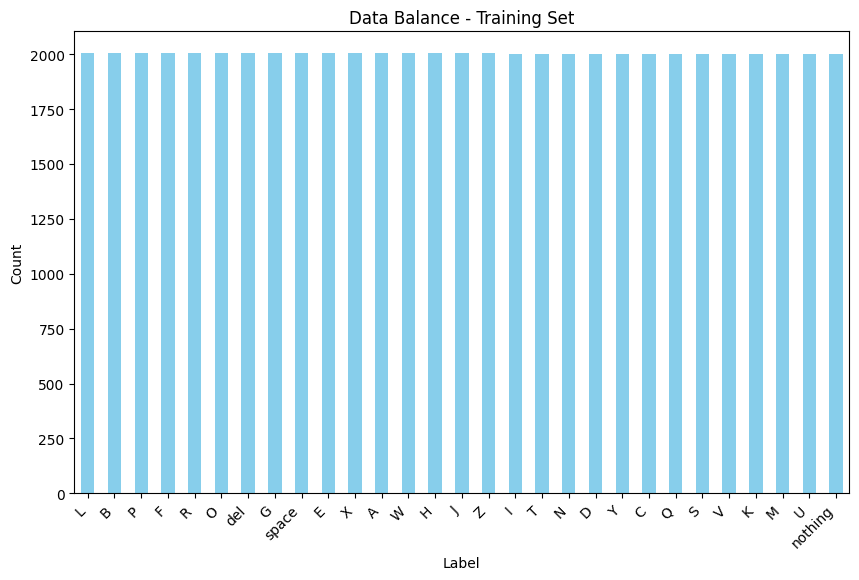

In [17]:
label_counts = data_train['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Data Balance - Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

In [18]:
# Data Augmentation (Just Rescale)
def data_augmentation():

    datagen = ImageDataGenerator(
    rescale=1/255,
    horizontal_flip=True,
    )

    # Training Dataset
    train_generator = datagen.flow_from_dataframe(
        data_train,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(img_height, img_width),
    )

    # Validation Dataset
    validation_generator = datagen.flow_from_dataframe(
        data_val,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=batch_size,
        target_size=(img_height, img_width),
    )

    # Testing Dataset
    test_generator = datagen.flow_from_dataframe(
        data_test,
        directory="./",
        x_col="image_path",
        y_col="label",
        class_mode="categorical",
        batch_size=1,
        target_size=(img_height, img_width),
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [19]:
train_generator, validation_generator, test_generator = data_augmentation()

Found 58103 validated image filenames belonging to 29 classes.
Found 15847 validated image filenames belonging to 29 classes.
Found 13050 validated image filenames belonging to 29 classes.


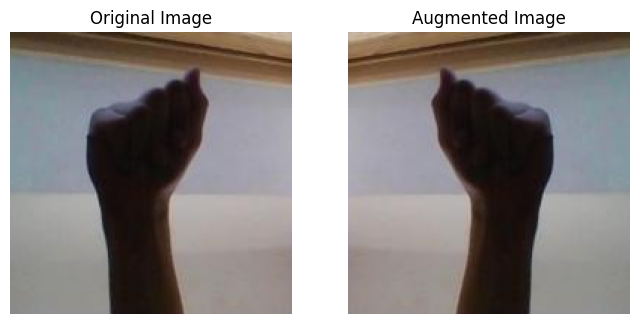

In [22]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

def visualize_augmentation(image_path):
    # Load the original image
    original_img = load_img(image_path)
    original_array = img_to_array(original_img)
    original_array = original_array.reshape((1,) + original_array.shape)  # Reshape to (1, height, width, channels)

    # Create an ImageDataGenerator for augmentation
    datagen = ImageDataGenerator(
        rescale=1. / 255,
        horizontal_flip=True,
    )

    # Generate one augmented image
    augmented_img = (datagen.flow(original_array).next()[0] * 255).astype('uint8')

    # Display the original and augmented images side by side
    plt.figure(figsize=(8, 4))

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')

    # Plot the augmented image
    plt.subplot(1, 2, 2)
    plt.imshow(augmented_img)
    plt.title('Augmented Image')
    plt.axis('off')

    plt.show()

# Example usage:
image_path = '/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train/A/A1.jpg'
visualize_augmentation(image_path)

#**Model Training**

#Basic CNN

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 6, 6, 128)         0

None

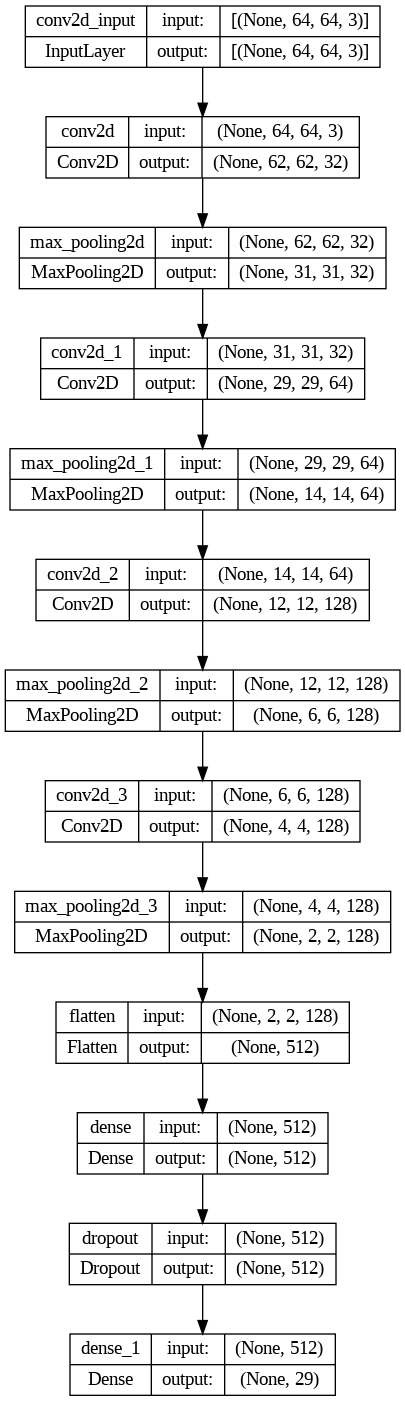

In [23]:
#simple CNN model
model_0 = Sequential()
model_0.add(Conv2D(32, (3, 3), activation='relu',input_shape=(img_height, img_width, img_channels)))
model_0.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model_0.add(Conv2D(64, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model_0.add(Conv2D(128, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model_0.add(Conv2D(128, (3, 3), activation='relu'))
model_0.add(MaxPooling2D(pool_size=(2, 2), strides=2))

model_0.add(Flatten())
model_0.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.005)))
model_0.add(Dropout(0.5))
model_0.add(Dense(29, activation='softmax'))

display(model_0.summary())
display(tf.keras.utils.plot_model(model_0, to_file='simple_nn.png', show_shapes=True))

**Training**

In [24]:
# Compile and train the model
model_0.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_0 = ModelCheckpoint('simple_cnn_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [25]:
# Train the Model
history_cnn = model_0.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_0]
)

Epoch 1/5
907/907 [==============================] - 60s 59ms/step - loss: 2.0895 - accuracy: 0.4201 - val_loss: 0.9326 - val_accuracy: 0.7611
Epoch 2/5
907/907 [==============================] - 60s 67ms/step - loss: 0.7801 - accuracy: 0.8116 - val_loss: 0.4904 - val_accuracy: 0.9176
Epoch 3/5
907/907 [==============================] - 79s 87ms/step - loss: 0.5215 - accuracy: 0.8948 - val_loss: 0.3601 - val_accuracy: 0.9515
Epoch 4/5
907/907 [==============================] - 67s 73ms/step - loss: 0.4262 - accuracy: 0.9246 - val_loss: 0.3179 - val_accuracy: 0.9637
Epoch 5/5
907/907 [==============================] - 52s 57ms/step - loss: 0.3641 - accuracy: 0.9415 - val_loss: 0.2925 - val_accuracy: 0.9660


## **VGG16 Transfer learning**

In [26]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

**Training**

In [27]:
# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint2 = ModelCheckpoint('asl_vgg16_best_weights2.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [28]:
history_vgg16 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint2]
)


Epoch 1/5
907/907 [==============================] - 71s 73ms/step - loss: 0.4977 - accuracy: 0.8783 - val_loss: 0.1251 - val_accuracy: 0.9754
Epoch 2/5
907/907 [==============================] - 56s 61ms/step - loss: 0.0755 - accuracy: 0.9859 - val_loss: 0.0520 - val_accuracy: 0.9887
Epoch 3/5
907/907 [==============================] - 54s 60ms/step - loss: 0.0386 - accuracy: 0.9933 - val_loss: 0.0417 - val_accuracy: 0.9891
Epoch 4/5
907/907 [==============================] - 54s 60ms/step - loss: 0.0265 - accuracy: 0.9949 - val_loss: 0.0354 - val_accuracy: 0.9921
Epoch 5/5
907/907 [==============================] - 56s 62ms/step - loss: 0.0222 - accuracy: 0.9953 - val_loss: 0.0302 - val_accuracy: 0.9920


##**DenseNet121**

29084464/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_2[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 32, 32, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati

None

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.684342 to fit



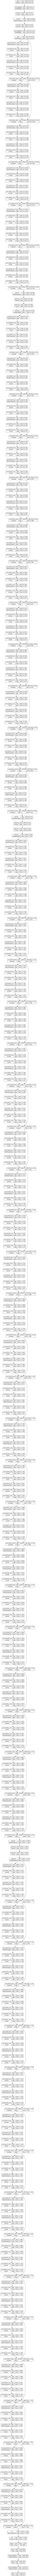

In [29]:
# Load EfficientNetB0 model and modify for ASL recognition
base_model_2 = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

for layer in base_model_2.layers:
    layer.trainable = False

x = base_model_2.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(29, activation='softmax')(x)

model_2 = Model(inputs=base_model_2.input, outputs=predictions)

display(model_2.summary())
display(tf.keras.utils.plot_model(model_2, to_file='DenseNet121.png', show_shapes=True))

**Training**

In [30]:
# Compile and train the model
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_2 = ModelCheckpoint('asl_denseNet121_best_weights.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [31]:
# Train the Model
history_densenet121 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint_2]
)

Epoch 1/5
907/907 [==============================] - 87s 84ms/step - loss: 0.3653 - accuracy: 0.8861 - val_loss: 0.2291 - val_accuracy: 0.9230
Epoch 2/5
907/907 [==============================] - 71s 78ms/step - loss: 0.1359 - accuracy: 0.9557 - val_loss: 0.1506 - val_accuracy: 0.9514
Epoch 3/5
907/907 [==============================] - 71s 78ms/step - loss: 0.0962 - accuracy: 0.9678 - val_loss: 0.1633 - val_accuracy: 0.9451
Epoch 4/5
907/907 [==============================] - 63s 69ms/step - loss: 0.0766 - accuracy: 0.9750 - val_loss: 0.1247 - val_accuracy: 0.9596
Epoch 5/5
907/907 [==============================] - 65s 71ms/step - loss: 0.0655 - accuracy: 0.9784 - val_loss: 0.0852 - val_accuracy: 0.9717


##**VGG16 Fine tuning**

In [33]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, img_channels))

x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(29, activation='softmax')(x)

model_3 = Model(inputs=base_model.input, outputs=predictions)

model_3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

**Training**

In [34]:
# Compile and train the model
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint3 = ModelCheckpoint('asl_vgg16_fine_tune_best_weights2.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [35]:
history_vgg16_finetune = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[checkpoint3]
)


Epoch 1/5
907/907 [==============================] - 107s 108ms/step - loss: 1.9519 - accuracy: 0.3711 - val_loss: 3.7791 - val_accuracy: 0.3118
Epoch 2/5
907/907 [==============================] - 96s 106ms/step - loss: 0.3675 - accuracy: 0.8732 - val_loss: 0.3301 - val_accuracy: 0.8888
Epoch 3/5
907/907 [==============================] - 86s 95ms/step - loss: 0.1315 - accuracy: 0.9565 - val_loss: 0.1970 - val_accuracy: 0.9428
Epoch 4/5
907/907 [==============================] - 86s 95ms/step - loss: 0.0833 - accuracy: 0.9731 - val_loss: 0.2452 - val_accuracy: 0.9238
Epoch 5/5
907/907 [==============================] - 87s 95ms/step - loss: 0.0674 - accuracy: 0.9778 - val_loss: 69.3432 - val_accuracy: 0.9744


#**Model Evaluation**

##**Model Testing**

In [36]:
scores = model_0.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy Simple CNN", scores[1]*100))
scores = model.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy VGG16", scores[1]*100))
scores = model_2.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy DenseNet121", scores[1]*100))
scores = model_3.evaluate(test_generator)
print("%s: %.2f%%" % ("Evaluate Test Accuracy fine tuned VGG16", scores[1]*100))

13050/13050 [==============================] - 59s 4ms/step - loss: 0.2821 - accuracy: 0.9700
Evaluate Test Accuracy Simple CNN: 97.00%
13050/13050 [==============================] - 82s 6ms/step - loss: 0.0283 - accuracy: 0.9929
Evaluate Test Accuracy VGG16: 99.29%
13050/13050 [==============================] - 193s 15ms/step - loss: 0.0784 - accuracy: 0.9737
Evaluate Test Accuracy DenseNet121: 97.37%
13050/13050 [==============================] - 78s 6ms/step - loss: 114.6519 - accuracy: 0.9763
Evaluate Test Accuracy fine tuned VGG16: 97.63%


##**Training Loss and Metrics**

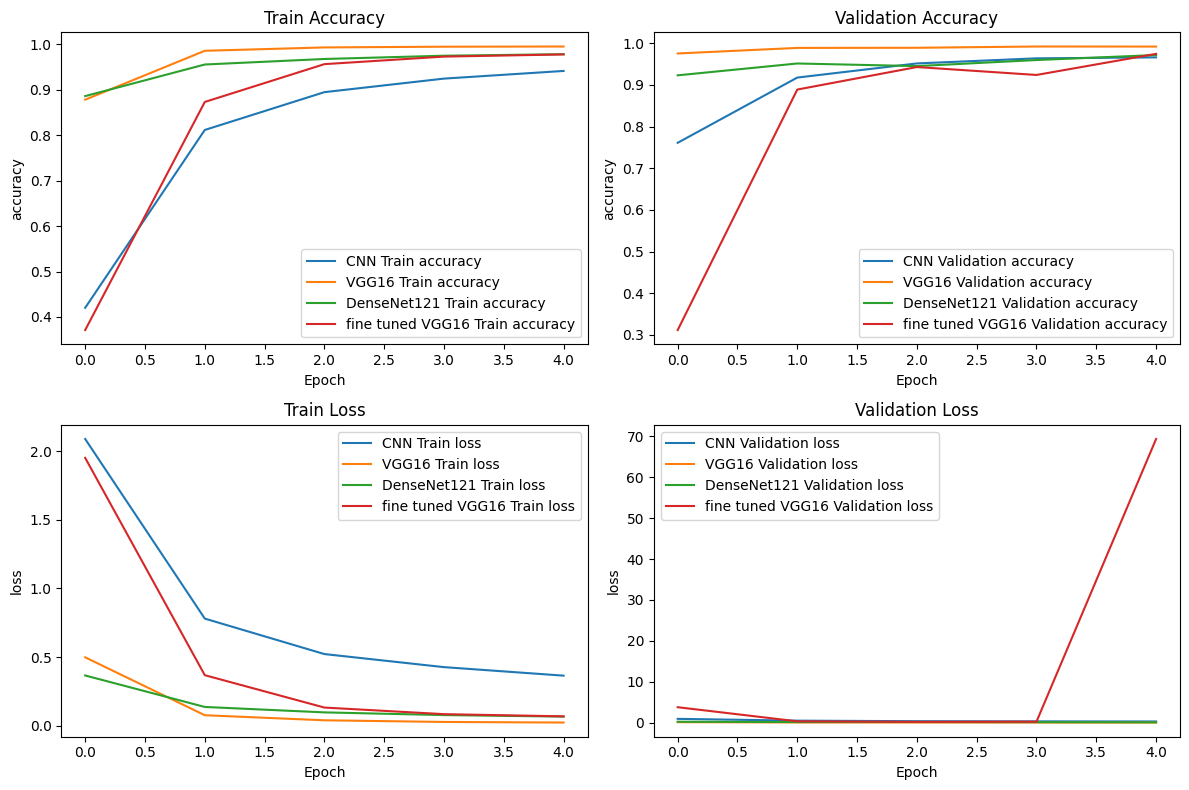

In [37]:
import matplotlib.pyplot as plt

# Assuming you have variables history_cnn, history_vgg16, and history_densenet121
# containing the training histories of your models.

def plot_metric_train(ax, history, metric, model_name):
    ax.plot(history.history[metric], label=f'{model_name} Train {metric}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()

def plot_metric_val(ax, history, metric, model_name):
    ax.plot(history.history[f'val_{metric}'], label=f'{model_name} Validation {metric}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric)
    ax.legend()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Plot Train and Validation Accuracy
axs[0, 0].set_title('Train Accuracy')
plot_metric_train(axs[0, 0], history_cnn, 'accuracy', 'CNN')
plot_metric_train(axs[0, 0], history_vgg16, 'accuracy', 'VGG16')
plot_metric_train(axs[0, 0], history_densenet121, 'accuracy', 'DenseNet121')
plot_metric_train(axs[0, 0], history_vgg16_finetune, 'accuracy', 'fine tuned VGG16')

axs[0, 1].set_title('Validation Accuracy')
plot_metric_val(axs[0, 1], history_cnn, 'accuracy', 'CNN')
plot_metric_val(axs[0, 1], history_vgg16, 'accuracy', 'VGG16')
plot_metric_val(axs[0, 1], history_densenet121, 'accuracy', 'DenseNet121')
plot_metric_val(axs[0, 1], history_vgg16_finetune, 'accuracy', 'fine tuned VGG16')

# Plot Train and Validation Loss
axs[1, 0].set_title('Train Loss')
plot_metric_train(axs[1, 0], history_cnn, 'loss', 'CNN')
plot_metric_train(axs[1, 0], history_vgg16, 'loss', 'VGG16')
plot_metric_train(axs[1, 0], history_densenet121, 'loss', 'DenseNet121')
plot_metric_train(axs[1, 0], history_vgg16_finetune, 'loss', 'fine tuned VGG16')

axs[1, 1].set_title('Validation Loss')
plot_metric_val(axs[1, 1], history_cnn, 'loss', 'CNN')
plot_metric_val(axs[1, 1], history_vgg16, 'loss', 'VGG16')
plot_metric_val(axs[1, 1], history_densenet121, 'loss', 'DenseNet121')
plot_metric_val(axs[1, 1], history_vgg16_finetune, 'loss', 'fine tuned VGG16')

plt.tight_layout()
plt.show()


##**Confusion Matrix**

In [39]:
# Confusion Matrix For Model_1
fine_tuned_model_0 = load_model("/content/simple_cnn_best_weights.h5")
predictions = fine_tuned_model_0.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix_0 = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 43s 3ms/step


In [41]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix_0,
        x=labels,
        y=labels,
        text=confusion_matrix_0,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [43]:
# Confusion Matrix For Model
fine_tuned_model_1 = load_model("/content/asl_vgg16_best_weights2.h5")
predictions = fine_tuned_model_1.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix_1 = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 79s 6ms/step


In [44]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix_1,
        x=labels,
        y=labels,
        text=confusion_matrix_1,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [45]:
# Confusion Matrix For Model_2
fine_tuned_model_2 = load_model("/content/asl_denseNet121_best_weights.h5")
predictions = fine_tuned_model_2.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix_2 = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 203s 15ms/step


In [46]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix_2,
        x=labels,
        y=labels,
        text=confusion_matrix_2,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

In [47]:
# Confusion Matrix For Model_3
fine_tuned_model_3 = load_model("/content/asl_vgg16_fine_tune_best_weights2.h5")
predictions = fine_tuned_model_3.predict(test_generator)

# Get the true labels from the generator
true_labels = test_generator.classes

# Compute the confusion matrix using tf.math.confusion_matrix
confusion_matrix_3 = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predictions.argmax(axis=1),
        num_classes=29)

13050/13050 [==============================] - 61s 5ms/step


In [48]:
# Create Figure
fig = go.Figure()

# Heatmap
fig.add_trace(
    go.Heatmap(
        z=confusion_matrix_3,
        x=labels,
        y=labels,
        text=confusion_matrix_3,
        texttemplate="<b>%{text}</b>",
        textfont={"size":8},
        colorscale=[[0, '#f4f4f4'],[1.0, '#76503d']],
        showscale = False,
        ygap = 5,
        xgap = 5,
        hovertemplate=
        '''
        Actual: %{y}<br>
        Predicted: %{x}<br>
        Total: %{text}
        ''',
        name="Confusion Matrix"
    )
)

# Update Axes
fig.update_xaxes(title="<b>Predicted Values</b>", tickfont_size=10)
fig.update_yaxes(title="<b>Actual Values</b>", tickfont_size=10)

# Update Layout
fig.update_layout(title_text='Confusion Matrix', title_x=0.5, font_size=14,
                  width=1050,
                  height=1115,
                  plot_bgcolor='white',
                  showlegend=False,
)

# Show
fig.show()

**Test with your own image**

In [49]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import load_model

# Load the model
model_path = '/content/asl_vgg16_best_weights2.h5'
loaded_model = load_model(model_path)

# Load and preprocess the image
image_path = 'hand.jpg'  # Replace with the path to your image
img = image.load_img(image_path, target_size=(64, 64))  # Adjust target_size based on your model's input size
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
predictions = loaded_model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions, axis=1)[0]

labels[predicted_class_index]

1/1 [==============================] - 0s 170ms/step


'A'

**Thank you ^^**